# Toxic Comment Classification

**Description.**

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The goal of this project is to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate.

This project was made for the [Kaggle competition](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge).

## Import libraries and read in data

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Union, Tuple
import time
from sklearn.model_selection import train_test_split
import re
from tqdm.auto import tqdm
from transformers import DistilBertTokenizer, RobertaTokenizer
from transformers import DistilBertModel, RobertaModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger  
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from sklearn import metrics
import pytorch_lightning as pl
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix
from sklearn.utils import class_weight

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
/kaggle/input/toxic-comments/sample_submission.csv
/kaggle/input/toxic-comments/test_labels.csv
/kaggle/input/toxic-comments/train.csv
/kaggle/input/toxic-comments/test.csv


In [2]:
train_df = pd.read_csv('../input/toxic-comments/train.csv')
test_df = pd.read_csv('../input/toxic-comments/test.csv')
test_labels = pd.read_csv('../input/toxic-comments/test_labels.csv')

In [3]:
print('Number of training samples is:', train_df.shape[0])
print('Number of test samples is:', test_df.shape[0])

Number of training samples is: 159571
Number of test samples is: 153164


In order to deter hand labeling, the test dataset contains some comments which are not included in scoring. Labels for comments that were not included in scoring have a value of -1. We are going to seperate these fake labels and only use the correct data for model evaluation.

In [4]:
test_labels_wrong = test_labels[test_labels['toxic'] == -1]
test_labels = test_labels[test_labels['toxic'] != -1]

In [5]:
test_df = test_df.merge(test_labels)
test_ids = test_df[['id']]

## EDA

Let's start with som simpe EDA: check if there are missing values, look at some sample rows to understand what kind of classes there are.

In [6]:
train_df.isnull().any().any(), test_df.isnull().any().any()

(False, False)

In [7]:
train_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
28756,4c2ba9becfa72598,Komsorg \n\nKomsorg is not a trade-union organ...,0,0,0,0,0,0
95111,fe44b987ef0199f2,ITN Credit \n\n - (here I am),0,0,0,0,0,0
111024,51fc1271dea2bf35,INEVERCRY YOU BETTER WATCH YO BACK BECAUSE I A...,1,0,1,1,1,0
104612,2fa8ddc5c1718ea6,"While I agree with that concept, the semi prot...",0,0,0,0,0,0
82921,dde1c91400c148dc,"""\n\nI agree that Raven has has a lot to do wi...",0,0,0,0,0,0


As we can see, the comments can be tagged in the following five categories:

* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate

Let's store these label names in a list:

In [8]:
label_columns = train_df.columns.tolist()[2:]

In [9]:
train_df[label_columns].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

There are 159571 samples in the training dataset. However, when we count the number of samples for each label, we can see that it doesn't add up. This means that there are a lot of samples whithout any of the tags.

In [10]:
target_sum=train_df.iloc[:,2:].sum(axis=1)
unlabelled_comments = (target_sum==0).sum()

print("Unlabelled comments:", unlabelled_comments)
print('Percentage of unlabelled comments:', unlabelled_comments/len(train_df)*100)

Unlabelled comments: 143346
Percentage of unlabelled comments: 89.83211235124176


Almost 90% of the comments are not tagged in any of the categories. Let's assume that all these comments are considered to be clean.

In [11]:
train_df['clean']=(target_sum==0)
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


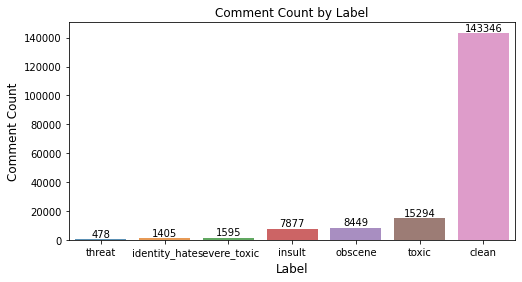

In [12]:
label_count=train_df.iloc[:,2:].sum().sort_values()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(label_count.index, label_count.values, alpha=0.8)
plt.title("Comment Count by Label")
plt.ylabel('Comment Count', fontsize=12)
plt.xlabel('Label', fontsize=12)
#adding the text labels
rects = ax.patches
labels = label_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems. 
The difference would be even bigger if we only considered clean and all of the negative comments.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


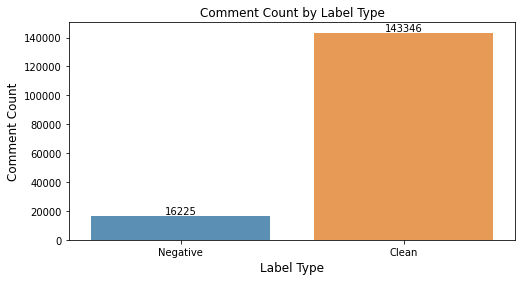

In [13]:
Type_count = pd.DataFrame({'Type': ['Negative', 'Clean'],
                   'Count': [(target_sum > 0).sum(), (target_sum == 0).sum()]})

#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(Type_count.Type, Type_count.Count, alpha=0.8)
plt.title("Comment Count by Label Type")
plt.ylabel('Comment Count', fontsize=12)
plt.xlabel('Label Type', fontsize=12)
#adding the text labels
rects = ax.patches
labels = Type_count.Count
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Again, we have a severe imbalance in favor of the clean comments. 

Some comments can be tagged with different classes. Let's see how many comments have multiple tags.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


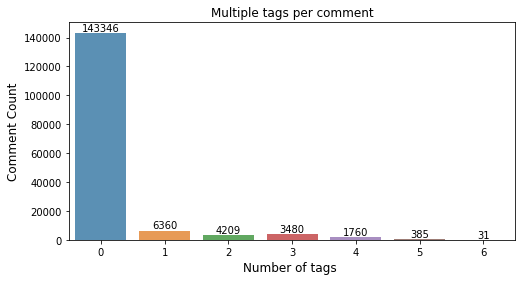

In [14]:
tag_count=target_sum.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(tag_count.index, tag_count.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('Comment Count', fontsize=12)
plt.xlabel('Number of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = tag_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Majority of the comments are not tagged in any of the categories. As the number of tags increases, the comment count decreases. Let's see if there are high correlations between some of these labels.

<AxesSubplot:title={'center':'Correlation between labels'}>

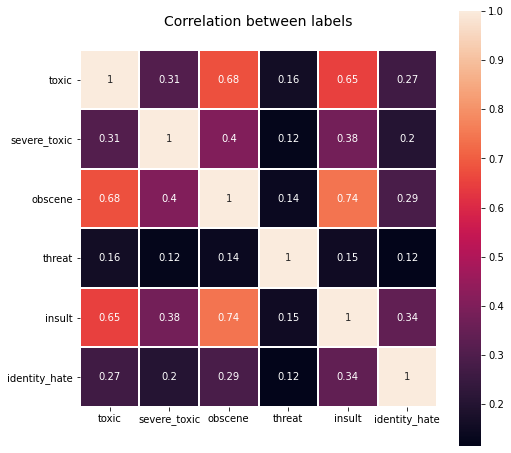

In [15]:
data = train_df[label_columns]

plt.figure(figsize=(8,8))
plt.title('Correlation between labels',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,
           linecolor='white',annot=True)

It looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene (0.68) and toxic-insult (0.65).

Finally, let's print some examples from each class.

In [16]:
def print_examples(dataframe: pd.DataFrame, label_columns: List[str]) -> None:
    '''Takes in a dataframe and a list of label columns and prints an example from each label'''
    for label in label_columns:
        print(f'{label}:')
        print(dataframe[dataframe[f'{label}']==1].iloc[4,1])
        print('----------------')

In [17]:
print_examples(train_df, label_columns)

toxic:
FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
----------------
severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!
----------------
obscene:
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
----------------
threat:
WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.
----------------
insult:
=Tony Sidaway is obviously a fistfuckee. He loves an arm up his ass.
----------------
identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie
----------------


## Preprocessing

First, let's deal with the class imbalace. We will do this by sampling 15,000 examples from the clean comments and create a new training set.

In [18]:
train_clean = train_df[train_df['clean'] == True]
train_negative = train_df[train_df['clean'] == False]

train_df = pd.concat([train_negative, train_clean.sample(16000)])
train_df.shape

(32225, 9)

Now it's time to clean the text. We are going to lower all the words and remove unwanted symbols.

In [19]:
def clean_text(text):
    text = text.lower()
    text = re.sub('[,\.!?:()"]', '', text)
    text = re.sub('[^a-zA-Z"]', ' ', text)
    
    text = text.strip(' ')
    return text

In [20]:
train_df['comment_text'] = train_df['comment_text'].map(lambda x : clean_text(x))
test_df['comment_text'] = test_df['comment_text'].map(lambda x : clean_text(x))
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0,False
12,0005c987bdfc9d4b,hey what is it talk what is it an exclusi...,1,0,0,0,0,0,False
16,0007e25b2121310b,bye don t look come or think of comming back...,1,0,0,0,0,0,False
42,001810bf8c45bf5f,you are gay or antisemmitian archangel white...,1,0,1,0,1,1,False
43,00190820581d90ce,fuck your filthy mother in the ass dry,1,0,1,0,1,0,False


## Dataset

Now let's tokenize the data using the  [DistilBert tokenizer](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer) and wrap the tokenization process in a PyTorch Dataset.

In [21]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, data: pd.DataFrame, max_sequence_length: int = 512):  
        
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case=True)
        self.data = data
        self.max_sequence_length = max_sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        data_row = self.data.iloc[idx]
        comment_text = data_row.comment_text
        labels = data_row[label_columns]
    
        encoded = self.tokenizer.encode_plus(
            text=comment_text,                      
            add_special_tokens = True,
            max_length = self.max_sequence_length,
            padding = 'max_length',
            return_attention_mask = True,
            truncation=True,
            return_tensors='pt',
        )
        
        encoded = {k:v.squeeze(0) for k,v in encoded.items()}
        encoded['labels'] = torch.tensor(labels, dtype=torch.float32)
        return encoded

In [22]:
train_dataset = ToxicCommentsDataset(train_df)
sample_item = train_dataset[0]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Now let's run some unit tests to make sure that our dataset class returns the right output. It should contain 3 types of information:
- input_ids - token indices, numerical representations of tokens building the sequences that will be used as input by the model.
- attention mask - indicates to the model which tokens should be attended to, and which should not. 
- labels - the expected prediction of the model.

In [23]:
assert "input_ids" in sample_item.keys()
assert "attention_mask" in sample_item.keys()
assert "labels" in sample_item.keys()
assert isinstance(sample_item['input_ids'], torch.Tensor)
assert isinstance(sample_item['attention_mask'], torch.Tensor)
assert isinstance(sample_item['labels'], torch.Tensor)

Finally, let's split the training dataset to training and validation datasets.

In [24]:
train_df, val_df = train_test_split(train_df, test_size=0.2)
train_df.shape, val_df.shape

((25780, 9), (6445, 9))

## Model

Now we can start the modeling process. Our model will use a pre-trained [DistilBertModel](https://huggingface.co/transformers/model_doc/distilbert.html#distilbertmodel) and a linear layer to convert the BERT representation to a classification task. Also, we are going to add a sigmoid activation to the output layer, which will squash the output between 0 and 1, thus we can treat the output as a probability to a sample belonging to a class. We are going to use Binary Cross-entropy loss since we want each output considered individually. We’ll pack everything in a [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html).

In [25]:
BATCH_SIZE = 32

class ToxicCommentModel(pl.LightningModule):
    def __init__(self, max_sequence_length: int = 512):
        super().__init__()      
        self.classifier = DistilBertModel.from_pretrained('distilbert-base-uncased', return_dict=True,
                                                output_attentions=True, output_hidden_states=True)
        self.linear = nn.Linear(self.classifier.config.hidden_size, 6)
        self.max_sequence_length = max_sequence_length
        self.criterion = nn.BCELoss()
        self.lr = 2e-5
        self.dropout = torch.nn.Dropout(0.2)
                                
    def forward(self, input_ids: torch.int64, attention_mask: torch.int64, labels: torch.float32 = None):        
        output = self.classifier(input_ids, attention_mask=attention_mask)
        hidden_state = output[0]
        pooler = hidden_state[:, 0]
        pooler = self.linear(pooler)
        pooler = self.dropout(pooler)
        output = torch.sigmoid(pooler)
    
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    def train_dataloader(self):
        dataset = ToxicCommentsDataset(train_df)
        loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4)
        return loader
    
    def val_dataloader(self):
        dataset = ToxicCommentsDataset(val_df)
        loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4)
        return loader
    
    def validation_step(self, batch: dict, batch_idx: int):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log_dict(
            {'val_loss': loss,
            'batch': batch_idx},
             prog_bar=True, logger=True
        )
        return {"loss": loss, "predictions": outputs, "labels": labels}
    
    def training_step(self, batch: dict, batch_idx: int):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log_dict(
            {'train_loss': loss,
            'batch': batch_idx},
             prog_bar=True, logger=True
        )
        return {"loss": loss, "predictions": outputs, "labels": labels}

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [27]:
model = ToxicCommentModel()

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [28]:
wandb_logger = WandbLogger(name='toxic-comments', project='toxic-comments', entity='dovilezal') 

trainer = pl.Trainer(
    logger=wandb_logger,
    max_epochs=1,
    gpus=1,
)
trainer.fit(model)

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

## Evaluation

Finally, it's time to evaluate the model performance.

In [29]:
test_dataset = ToxicCommentsDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
model = model.to(device)

First we need to call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. 

In [30]:
model = model.eval().to(device)

predictions = []
labels = []
losses = []
times = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch = {k:v.to(device) for k,v in batch.items()}
        start_time = time.time()
        loss, prediction = model(**batch)
        end_time = time.time()
        
        times.append(end_time - start_time)
        predictions.append(prediction)
        labels.append(batch['labels'])
        losses.append(loss.item())

In [31]:
print(f"Inference speed: {sum(times)/len(times)} sec")

Inference speed: 0.010186371207237244 sec


Now we need concatenate results from the batches into one and convert it into numpy arrays after copying the tensor to host memory.

In [32]:
predictions = torch.cat(predictions)
labels = torch.cat(labels)

In [33]:
predictions = predictions.cpu().numpy()
labels = labels.cpu().numpy()

This Kaggle competition is evaluated on the average of the individual AUROCs of each predicted column. Therefore, let's calculate AUROC per label an the average. 

the AUROC tells you the probability that a randomly selected positive instance  will have a higher predicted probability of being positive than a randomly selected negative instance.

In [34]:
print("AUROC per label")
total = 0
for i, name in enumerate(label_columns):
    tag_auroc = metrics.roc_auc_score(labels[:, i], predictions[:, i])
    total += tag_auroc
    print(f"{name}: {tag_auroc}")
    
print("Average AUROC: ", total/len(label_columns))

AUROC per label
toxic: 0.9693488944394975
severe_toxic: 0.9886837730540067
obscene: 0.9780965735213001
threat: 0.9925464351593408
insult: 0.9794950082882719
identity_hate: 0.9904076092844303
Average AUROC:  0.9830963822911413


The results seem to be quite good, however, the output of the model is a vector of probabilities. We should apply a threshold to decide if a comment belongs to certain classes or not. The threshold is quite low because it helps improve the AUROC metric score. This way we can be certain that most of the toxic comments are going to be identified.

In [58]:
upper, lower = 1, 0
threshold = 0.2
predictions_threshold = np.where(predictions > threshold, upper, lower)

In [59]:
print("AUROC per label")
total = 0
for i, name in enumerate(label_columns):
    tag_auroc = metrics.roc_auc_score(labels[:, i], predictions_threshold[:, i])
    total += tag_auroc
    print(f"{name}: {tag_auroc}")
    
print("Average AUC: ", total/len(label_columns))

AUROC per label
toxic: 0.832452040903855
severe_toxic: 0.935497806254869
obscene: 0.9215030935943418
threat: 0.7806575434544469
insult: 0.918175459092651
identity_hate: 0.9222876115719006
Average AUC:  0.8850955924786774


As we can see now, the results are a bit worse. Let's look at the [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

In [60]:
print(classification_report(
  labels,
  predictions_threshold,
  target_names=label_columns,
  zero_division=0
))

               precision    recall  f1-score   support

        toxic       0.24      1.00      0.39      6090
 severe_toxic       0.16      0.90      0.27       367
      obscene       0.32      0.97      0.48      3691
       threat       0.41      0.56      0.48       211
       insult       0.27      0.98      0.43      3427
identity_hate       0.34      0.86      0.48       712

    micro avg       0.26      0.97      0.42     14498
    macro avg       0.29      0.88      0.42     14498
 weighted avg       0.27      0.97      0.42     14498
  samples avg       0.07      0.10      0.08     14498



As we can see, this model favors recall over precision. Toxic comments will almost always be identified, followed by obscene and insulting comments. However, comment labels with less support have worse recall scores. Finally, let's look at the confusion matrices for each label.

In [38]:
print(multilabel_confusion_matrix(y_true=labels.astype(int), y_pred=predictions_threshold))

[[[38547 19341]
  [    6  6084]]

 [[61818  1793]
  [   37   330]]

 [[52570  7717]
  [  107  3584]]

 [[63597   170]
  [   92   119]]

 [[51596  8955]
  [   54  3373]]

 [[62052  1214]
  [   97   615]]]


In [39]:
def get_confusion_matrix(labels: pd.DataFrame, one_class: str, predictions: pd.DataFrame) -> pd.DataFrame:
    """Compute confusion matrix for one class
        Args:
            labels (pd.DataFrame): contains 0 or 1 for each class
            one_class (str): class name
            predictions (pd.DataFrame): contains 0 or 1 for each class
    """
    confusion_matrix_array = confusion_matrix(
        y_true=labels[[one_class]],
        y_pred=predictions[[one_class]]
    )
    return (
        pd.DataFrame(
            confusion_matrix_array,
            index=["other", one_class],
            columns=["other", one_class],
        )
    )


def plot_confusion_matrix(labels: pd.DataFrame, predictions: pd.DataFrame) -> None:
    """Plot confusion matrix for multilabels
        Args:
            labels (pd.DataFrame): contains 0 or 1 for each class
            predictions (pd.DataFrame): contains 0 or 1 for each class
    """
    size = labels.shape[1]
    fig, axes = plt.subplots(size, 1, figsize=(8, 5 * size))
    for i, one_class in enumerate(labels.columns):
        cm_df = get_confusion_matrix(labels, one_class, predictions)
        sns.heatmap(ax=axes[i], data=cm_df, annot=True, vmin=0)
        axes[i].set_xlabel("True", fontsize=12)
        axes[i].set_ylabel("Predicted", fontsize=12)
        axes[i].set_title(one_class, fontsize=15)
    fig.tight_layout()

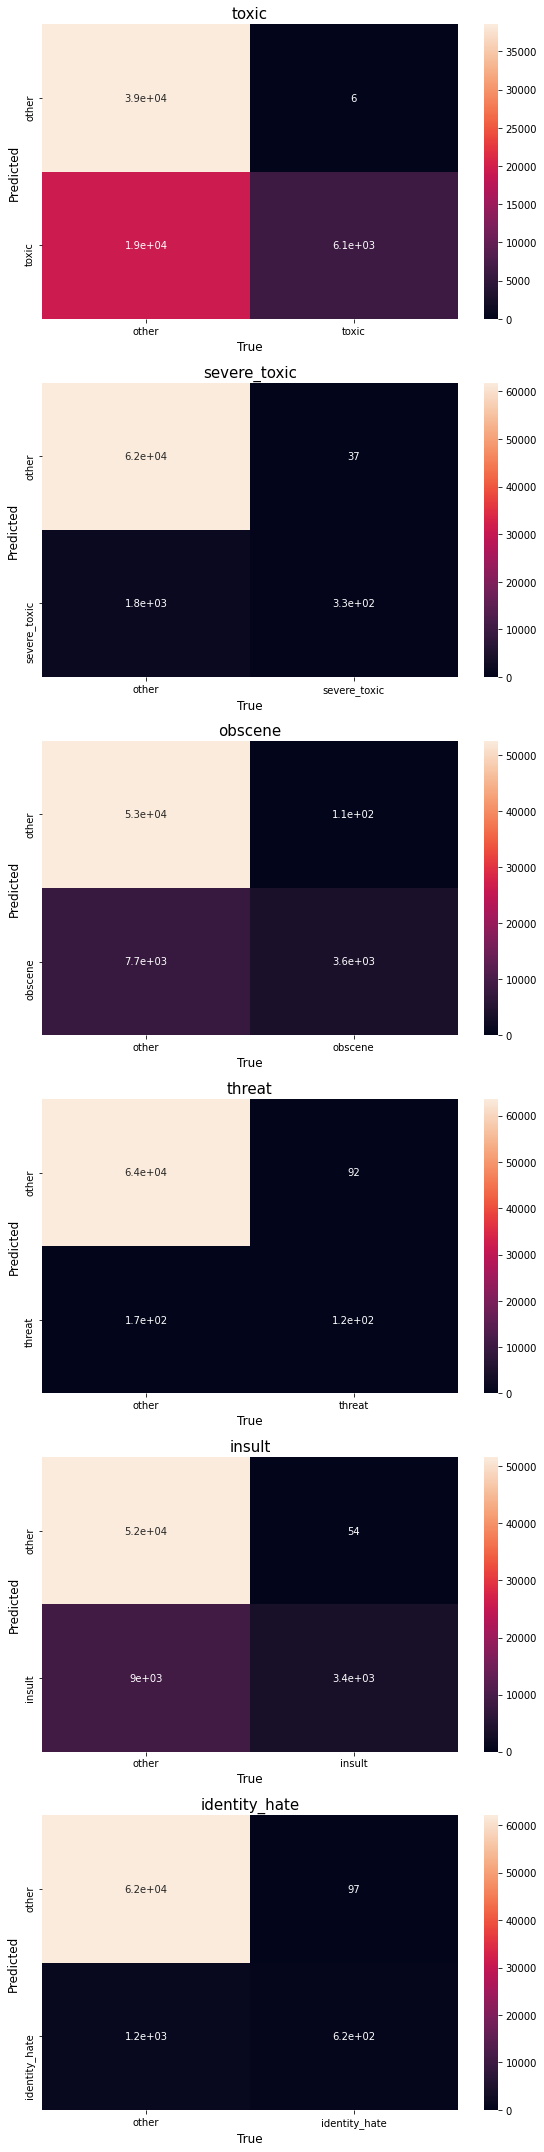

In [40]:
plot_confusion_matrix(
    pd.DataFrame(predictions_threshold, columns=label_columns),
    pd.DataFrame(labels, columns=label_columns)
)

Again, we can see that false negatives have the lowest numbers, which means that the majority of negative comments get identified. However, there are also a lot of false positives. This dosn't necessarily mean that clean comments get wrongfully tagged as negative comments. More likely, negative comments are identified but tagged in a wrong category, i.e., a *toxic* comment could get tagged as *severe toxic*. 

### Kaggle submission

In [41]:
sample_submission = pd.read_csv('../input/toxic-comments/sample_submission.csv')

In [42]:
predictions_threshold

array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0],
       ...,
       [1, 0, 1, 0, 1, 1],
       [1, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0]])

In [43]:
df = pd.DataFrame(predictions_threshold, columns = label_columns).reset_index(drop=True)

In [44]:
submission = pd.concat([test_ids, df], axis=1)
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,0,0,0,0,0,0
1,000247e83dcc1211,1,0,0,0,1,0
2,0002f87b16116a7f,1,0,0,0,1,0
3,0003e1cccfd5a40a,0,0,0,0,0,0
4,00059ace3e3e9a53,0,0,0,0,0,0


In [45]:
submission = pd.concat([submission, test_labels_wrong])
submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,0,0,0,0,0,0
1,000247e83dcc1211,1,0,0,0,1,0
2,0002f87b16116a7f,1,0,0,0,1,0
3,0003e1cccfd5a40a,0,0,0,0,0,0
4,00059ace3e3e9a53,0,0,0,0,0,0
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [46]:
submission.to_csv('submission.csv', index=False)